# Lab | Unsupervised learning intro

#### Instructions 


It's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.

The experiments you did with the `Spotify` API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:

1. Check whether or not the song is in the Billboard Hot 200.
2. Collect the audio features from the `Spotify` API.

After that, you want to send the `Spotify` audio features of the submitted song to the clustering model, which should return a cluster number.

##### 0. Train a clustering model on the song database

In [4]:
# Import relevant libraries
import numpy as np 
import pandas as pd
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import getpass
from sklearn.cluster import KMeans
import random
from sklearn.metrics import pairwise_distances_argmin_min


In [2]:
# Create connection to Spotify API
client_id = "31bb38d4d2c54b0e9b994db2a71040d5"
client_secret = "86dc73ebcd4848b4a6c0ee54227fd223"

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))

In [3]:
# Import the song database
song_database = pd.read_csv("song_database.csv", index_col="song_id")

In [4]:
# Save audio features for the songs in a dataframe
audio_database = pd.DataFrame(columns=['danceability', 'energy', 'key', \
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', \
    'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href', \
    'analysis_url', 'duration_ms', 'time_signature'])

for song_id in song_database.index:
    audio_features = sp.audio_features(tracks=song_id)[0]
    audio_database = audio_database.append(audio_features, ignore_index=True)

# Set the database index to the song id
audio_database.set_index("id", drop=True, inplace=True)

Save the database for future use:

In [7]:
audio_database.to_csv("audio_database.csv")

In [14]:
audio_database.type.unique()

array(['audio_features'], dtype=object)

In [15]:
# Remove the columns unnecessary for the training
to_drop = ["uri", "track_href", "analysis_url", "type"]
audio_database.drop(to_drop, inplace=True, axis=1)

In [16]:
round(audio_database.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
danceability,3935.0,0.55,0.19,0.00,0.42,0.59,0.70,0.98
energy,3935.0,0.33,0.25,0.00,0.10,0.30,0.48,1.00
loudness,3935.0,-15.53,8.45,-43.30,-21.80,-12.93,-9.12,-1.01
speechiness,3935.0,0.07,0.07,0.00,0.04,0.04,0.07,0.95
acousticness,3935.0,0.65,0.34,0.00,0.36,0.79,0.96,1.00
liveness,3935.0,0.14,0.10,0.03,0.10,0.11,0.13,0.93
valence,3935.0,0.35,0.23,0.00,0.16,0.30,0.50,0.98
tempo,3935.0,111.68,33.61,0.00,82.04,107.55,136.59,240.05


In [21]:
# Scale numerical features
from sklearn.preprocessing import StandardScaler
X = audio_database.copy()
X_prep = StandardScaler().fit_transform(X)
X_prep = pd.DataFrame(X_prep, columns=X.columns, index=X.index)
pd.DataFrame(X_prep).head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
id,,,,,,,,,,,,,
4kbj5MwxO1bq9wjT5g9HaA,0.134362,2.165122,-1.172005,1.387864,0.820393,-0.107979,-1.877779,-1.652850,1.147025,1.164524,0.486647,0.325785,0.301204
0B9x2BRHqj3Qer7biM3pU3,1.069031,1.147740,-1.452530,0.488420,0.820393,-0.137468,-1.077812,-1.645325,-0.440362,2.034510,-0.140992,-0.126654,0.301204
68y6OIiE1nDdI1MLQdJNh8,0.679586,1.448148,0.230623,1.147705,-1.218928,-0.592426,-1.197519,-1.652850,-0.090665,0.663104,-0.376360,0.541591,0.301204
5Q0Nhxo0l2bP3pNjpGJwV1,0.518615,1.492208,1.352724,1.285717,-1.218928,-0.387414,-1.894976,-1.652550,-0.507158,0.525964,-0.466044,0.372003,0.301204
4cluDES4hQEUhmXj6TXkSo,0.902868,1.848692,-0.330428,1.542921,0.820393,0.057715,-1.871969,-1.652850,-0.792023,2.317362,0.395951,0.339819,0.301204


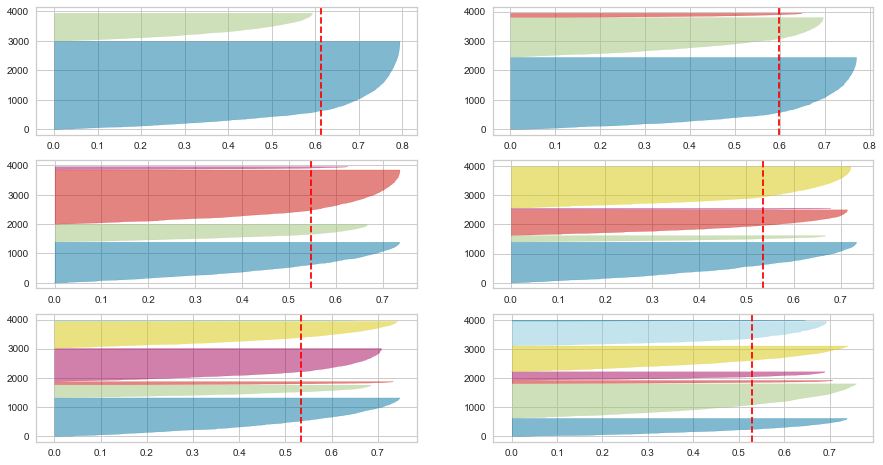

In [22]:
from yellowbrick.cluster import SilhouetteVisualizer
from matplotlib import pyplot as plt
fig, ax = plt.subplots(3, 2, figsize=(15, 8))
for i in range(2, 8):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

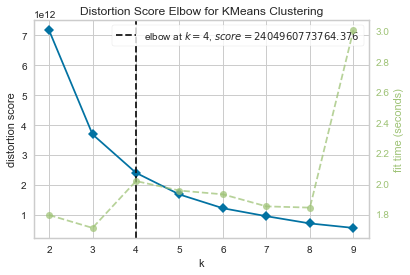

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# Instantiate the clustering model and visualizer
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(km, k=(2, 10))
visualizer.fit(X)    
# Draw/show/poof the data
visualizer.poof()    

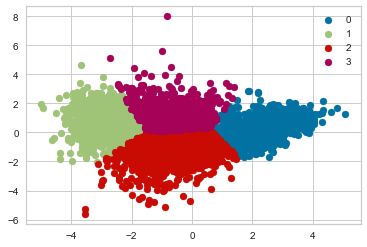

In [24]:
from sklearn.decomposition import PCA

# Transform the data into 2D so we can see
pca = PCA(2) 
X_2D = pca.fit_transform(X_prep)
X_2D

# We'll use k=4 based on the elbow & silhouette scores
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_2D)

# And we'll plot the clusters to have a visual representation of their assignment
clusters = kmeans.predict(X_2D)
labels = np.unique(clusters)

for i in labels:
    plt.scatter(X_2D[clusters==i, 0] , X_2D[clusters==i, 1] , label = i)
plt.legend()
plt.show()

Save the song information and audio features in the same dataframe:

In [45]:
audio_database.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'cluster'],
      dtype='object')

In [46]:
database = song_database.join(audio_database)

Check that the join occurred correctly:

In [48]:
database.shape

(3935, 16)

In [47]:
database.isna().sum()

song_name           0
artist_name         0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
cluster             0
dtype: int64

In [49]:
database.to_csv("database.csv")

##### 1. Check if the song is in the Billboard Hot 200

In [ ]:
new_song = input("Write a song you like:")
new_artist = input("Write the artist of that song:")

In [ ]:
hot_100 = pd.read_csv("billboard_hot_100.csv")

if new_song in hot_100.Song and new_artist in hot_100.Artist:
    print("This song is hot right now!")
else:
    print("This song is not that popular nowadays.")

This song is not that popular nowadays.


##### 2. Collect the song audio features

In [25]:
# Ask the user for a song until they find something within the database
song_found = True

while song_found == True:
    try:
        new_song_id = song_database[(song_database["song_name"] == new_song) & \
        (song_database["artist_name"] == new_artist)].index[0]
        song_found = False

    except:
        print("Sorry, we couldn't find this song on Spotify")
        new_song = input("Please add another song you like:")
        new_artist = input("And add the name of the artist:")    

Sorry, we couldn't find this song on Spotify


In [26]:
# Get the song features for the recommendation system
new_song_features = sp.audio_features(tracks=new_song_id)[0]
new_song_features = pd.DataFrame(new_song_features, index=[new_song_id], \
    columns=new_song_features.keys())
new_song_features.drop("id", axis=1, inplace=True)

# Remove the unnecessary items
new_song_features.drop(to_drop, axis=1, inplace=True)

##### 3. Test the clustering model on submitted songs and make a recommendation from the same cluster

In [31]:
# Get the cluster number for the items in the audio database
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_prep)
clusters = kmeans.predict(X_prep)

In [40]:
# Add the cluster number to the audio_database and save the data
audio_database["cluster"] = clusters
audio_database.to_csv("audio_database.csv")

In [41]:
# Getting nearest point
closest, _ = pairwise_distances_argmin_min(new_song_features, audio_database.drop("cluster", axis=1))

In [42]:
closest

array([3])

##### 4. Creating the song recommender

In [24]:
def input_song():
    new_song = input("Write a song you like:")
    new_artist = input("Write the artist of that song:")
    return new_song, new_artist

def check_popularity(hot_100_list):
    '''
    Checks if a song is in the Hot 100 Billboard list

    Arguments
    hot_100_list = The name of the .csv file where the scraped Hot 100 list is saved

    Returns
    is_pop = A Boolean to show if the song is in the Hot 100 Billboard list
    '''
    current_dir = os.getcwd()
    hot_100_list_path = os.path.join(current_dir, hot_100_list)
    hot_100 = pd.read_csv(hot_100_list_path)

    if new_song in hot_100.Song and new_artist in hot_100.Artist:
        print("This song is hot right now!")
        is_pop = 1
    else:
        print("This song is not that popular nowadays.")
        is_pop = 0
    return is_pop

def get_recommendation(new_song, new_artist, song_database):
    # Check the song is in the database, if not, input another song
    song_found = True
    while song_found == True:
        try:
            new_song_id = song_database[(song_database["song_name"] == new_song) & \
            (song_database["artist_name"] == new_artist)].index[0]
            new_song_features = song_database.loc[new_song_id, :]
            new_song_features.drop(["song_name", "artist_name"], inplace=True)
            song_found = False
        except:
            print("Sorry, we couldn't find this song on Spotify")
            new_song, new_artist = input_song()
    new_song_features = new_song_features.to_frame().T
    recommended_cluster, _ = pairwise_distances_argmin_min(new_song_features.drop("cluster", axis=1), \
        song_database.drop(["song_name", "artist_name", "cluster"], axis=1))
    full_cluster = song_database[song_database.cluster == recommended_cluster[0]]
    recommendation_id = random.choice(full_cluster.index)
    return recommendation_id  

In [23]:
recommended_cluster[0]

3

In [29]:
def song_recommender(database_name):
    # Read database into dataframe
    current_dir = os.getcwd()
    database_path = os.path.join(current_dir, database_name)
    song_database = pd.read_csv(database_path, index_col="song_id")

    # Run recommendation engine
    recommend = True
    satisfied = True
    while recommend:
        new_song, new_artist = input_song()
        while satisfied:
            recommendation_id = get_recommendation(new_song, new_artist, song_database)
            recommended_song = song_database.loc[recommendation_id, "song_name"]
            recommended_artist = song_database.loc[recommendation_id, "artist_name"]
            print("You could try out {} from {}!".format(recommended_song, recommended_artist))
            satisfied = input("Are you satisfied with your recommendation? (Y/N):")
            if satisfied.lower() == "y":
                satisfied = False
        recommend = input("Would you like another recommendation? (Y/N):")
        if recommend.lower() == "n":
            recommend = False


In [18]:
song_database = pd.read_csv("database.csv", index_col="song_id")
new_song = "Party In The U.S.A."
new_artist = "Miley Cyrus"
new_song_id = song_database[(song_database["song_name"] == new_song) & \
(song_database["artist_name"] == new_artist)].index[0]
new_song_features = song_database.loc[new_song_id, :]
new_song_features.drop(["song_name", "artist_name"], inplace=True)
new_song_features = new_song_features.to_frame().T
recommended_cluster, _ = pairwise_distances_argmin_min(new_song_features.drop("cluster", axis=1), \
        song_database.drop(["song_name", "artist_name", "cluster"], axis=1))

/home/sabina/.local/lib/python3.8/site-packages/pandas/core/generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


In [30]:
song_recommender("database.csv")

/home/sabina/.local/lib/python3.8/site-packages/pandas/core/generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


You could try out Saudade (When We Are Born) from Ólafur Arnalds!


/home/sabina/.local/lib/python3.8/site-packages/pandas/core/generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


You could try out Silhouette from Robert Gafforelli!


/home/sabina/.local/lib/python3.8/site-packages/pandas/core/generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


You could try out line up from Golden Horses!
